In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

**Persiapan Data**

In [ ]:
# Membaca data
dataFrame = pd.read_csv('https://github.com/Adkurrr/K-means-without-machine-learning-library/blob/main/factbook.csv?raw=true')
dataFrame.head()

,Unnamed: 0,Country,Area,Birth rate,Current account balance,Death rate,Electricity consumption,Electricity production,Exports,GDP,...,Population,Public debt,Railways,Reserves of foreign exchange & gold,Total fertility rate,Unemployment rate,Continent,Energy consumption,Total GDP,Electricity
0,0,Japan,377835,9.47,170200000000,8.95,971000000000,1044000000000,538800000000,3745000000000,...,1274172440,164.3,23705,6646000000000,1.39,4.7,Asia,1775252900000,37460669736000,73000000000
1,1,Germany,357021,8.33,73590000000,10.55,519500000000,560000000000,893300000000,2362000000000,...,824313900,65.8,46039,968400000000,1.39,10.6,Europe,1515028910000,23657808930000,40500000000
2,2,Saudi Arabia,1960582,29.56,51500000000,2.62,128500000000,138200000000,113000000000,310200000000,...,264175990,75.0,1392,236200000000,4.05,25.0,Asia,692515500000,3170111880000,9700000000
3,3,Russia,17075200,9.80,46040000000,14.52,894300000000,915000000000,162500000000,1408000000000,...,1434203090,28.2,87157,1245000000000,1.27,8.3,Asia,4952323100000,14055190282000,20700000000
4,4,Switzerland,4129,9.77,40950000000,8.48,54530000000,63470000000,130700000000,251900000000,...,74893700,57.2,4533,695800000000,1.42,3.4,Europe,85460002904,2531407060000,8940000000


In [ ]:
# Memilih atribut yang akan digunakan
df = dataFrame[['Exports', 'Imports', 'Industrial production growth rate', 'Investment', 'Unemployment rate']]
df.head()

,Exports,Imports,Industrial production growth rate,Investment,Unemployment rate
0,538800000000,401800000000,6.6,24.0,4.7
1,893300000000,716700000000,2.2,17.6,10.6
2,113000000000,36210000000,2.8,17.2,25.0
3,162500000000,92910000000,6.4,19.1,8.3
4,130700000000,121100000000,4.7,20.4,3.4


Normalisasi Data

In [ ]:
# Membuat fungsi min-max scaler
def minMax_scaler(df):
    return (df - df.min()) / (df.max() - df.min())
# Realisasi normalisasi
df = df.apply(minMax_scaler)

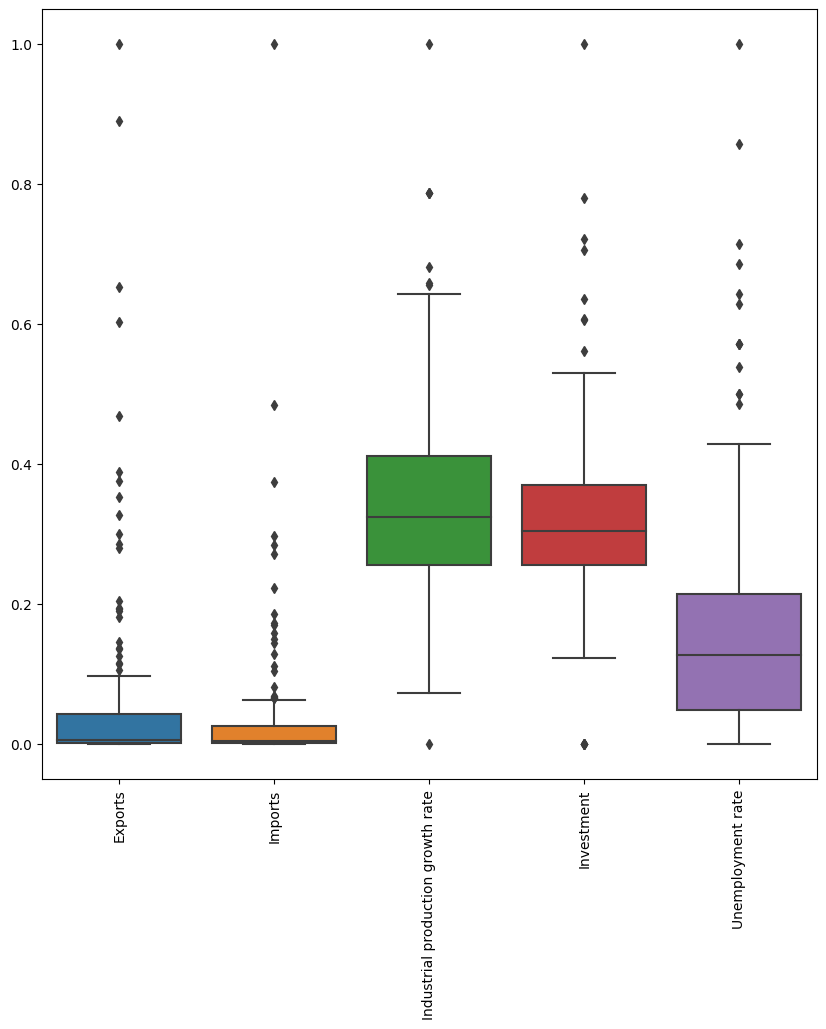

In [ ]:
# Cek outliers
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Menggantikan nilai outliers dengan threshold
def outlier_threshold(df, col, q1=0.25, q3=0.75):
    quartile1 = df[col].quantile(q1)
    quartile3 = df[col].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_threshold(df, col):
    low, up = outlier_threshold(df, col)
    df[col] = np.where(df[col] > up, up, np.where(df[col] < low, low, df[col]))
    return df

for i in df.columns:
    df = replace_with_threshold(df, i)

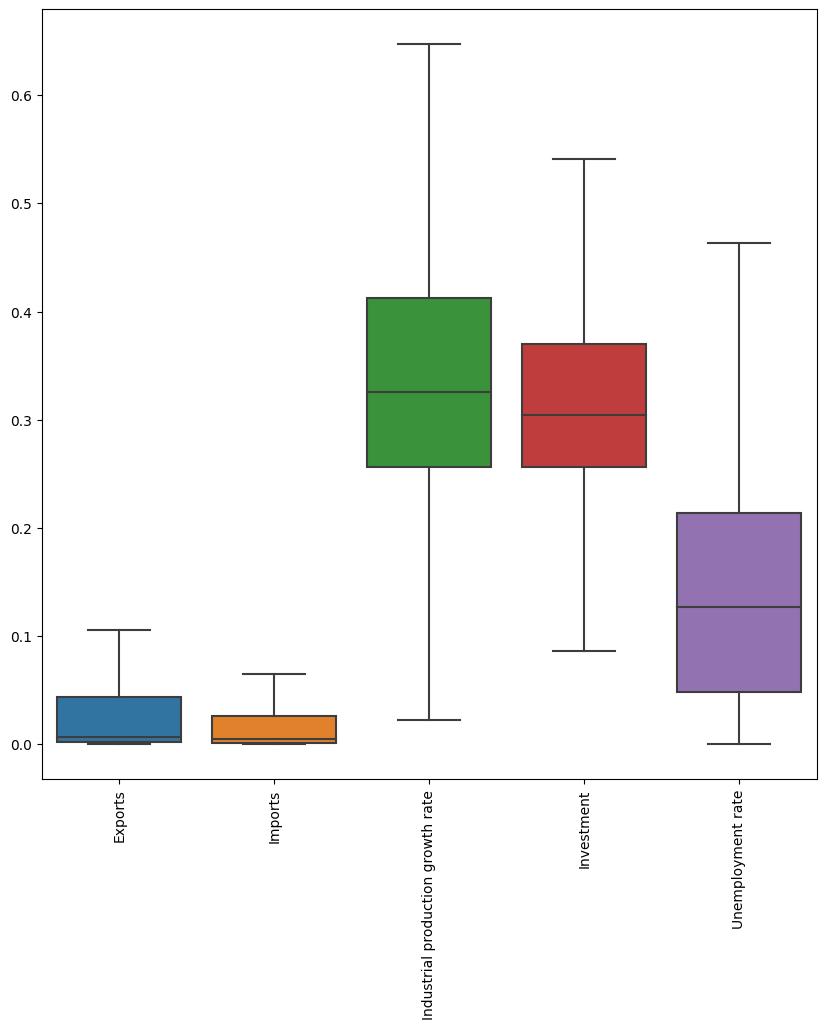

In [ ]:
#cek outliers setelah diganti threshold
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

**Membuat Fungsi K-means**

In [ ]:
# Membuat centroid secara random sebanyak k dari dataset
def random_centroid(df, k):
    centroid = []
    for _ in range(k):
        centroid.append(df.sample().values[0])
    return centroid

# Mendefinisikan cluster menggunakan euclidean distance
def assign_cluster(df, initial_centroid, k):
    cluster = []
    for i in range(len(df)):
        euclidean_distance = []
        for j in range(k):
            euclidean_distance.append(np.linalg.norm(np.subtract(df.iloc[i], initial_centroid[j])))
        cluster.append(np.argmin(euclidean_distance))
    return cluster

# Menghitung centroid hingga konvergen
def compute_centroid(df, cluster, k):
    centroids = []
    for i in range(k):
        temp = []
        for j in range(len(df)):
            if cluster[j] == i:
                temp.append(df.iloc[j])
        centroids.append(np.mean(temp, axis=0))
    return centroids

# Menghitung perbedaan centroid lama dan centroid baru
def difference(old, new):
    diff = 0
    for i in range(len(old)):
        diff += np.linalg.norm(np.subtract(old[i], new[i]))
    return diff

In [ ]:
# Memanggil fungsi k-means
def kmeans(df, k):
    initial_centroid = random_centroid(df, k)
    cluster = assign_cluster(df, initial_centroid, k)
    new_centroid = compute_centroid(df, cluster, k)
    while difference(initial_centroid, new_centroid) > 0.001:
        initial_centroid = new_centroid
        cluster = assign_cluster(df, initial_centroid, k)
        new_centroid = compute_centroid(df, cluster, k)
    df['cluster'] = cluster
    return df

**Menghitung Inersia Menggunakan Elbow Method**

In [ ]:
# Menghitung wcss inertia untuk setiap cluster
def inertia(df, cluster, k):
    wcss = []
    for i in range(k):
        temp = []
        for j in range(len(df)):
            if cluster[j] == i:
                temp.append(df.iloc[j])
        wcss.append(np.sum(np.linalg.norm(np.subtract(temp, np.mean(temp, axis=0)), axis=1)))
    return np.sum(wcss)

# Menghitung nilai wcss inertia untuk setiap k
def k_means_inertia(df, n_cluster):
    initial_centroid = random_centroid(df, n_cluster)
    cluster = assign_cluster(df, initial_centroid, n_cluster)
    new_centroid = compute_centroid(df, cluster, n_cluster)
    while difference(initial_centroid, new_centroid) > 0.001:
        initial_centroid = new_centroid
        cluster = assign_cluster(df, initial_centroid, n_cluster)
        new_centroid = compute_centroid(df, cluster, n_cluster)
    return inertia(df, cluster, n_cluster)

# Menampilkan visualisasi wcss inertia
def show_visualizer(df, k):
    inertia_list = []
    for i in range(1, k):
        inertia_list.append(k_means_inertia(df, i))

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, k), inertia_list, marker='o')
    for i, v in enumerate(inertia_list):
        plt.text(i+1, v, round(v, 2), ha='center', va='bottom')

    plt.xlabel('Number of cluster')
    plt.ylabel('wcss')
    plt.show()

**Visualisasi**

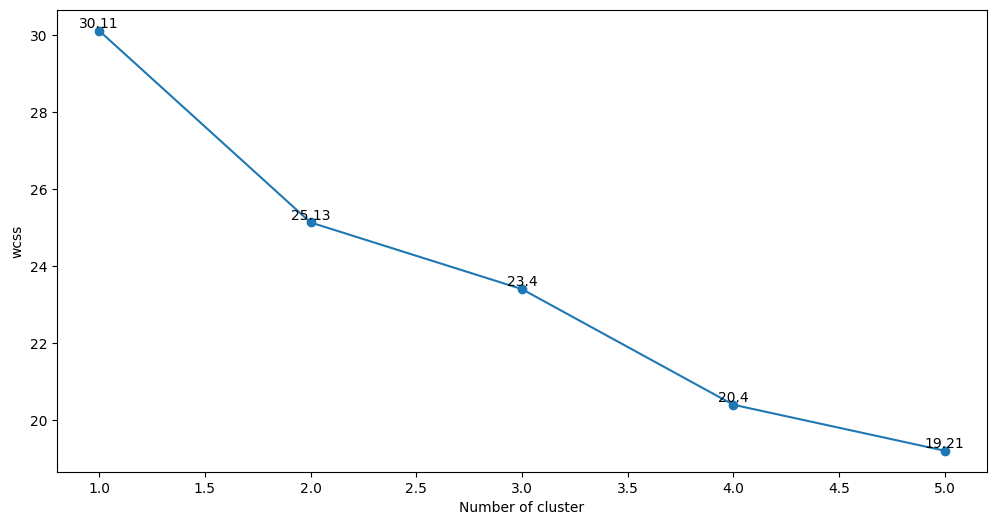

In [ ]:
show_visualizer(df, 6)

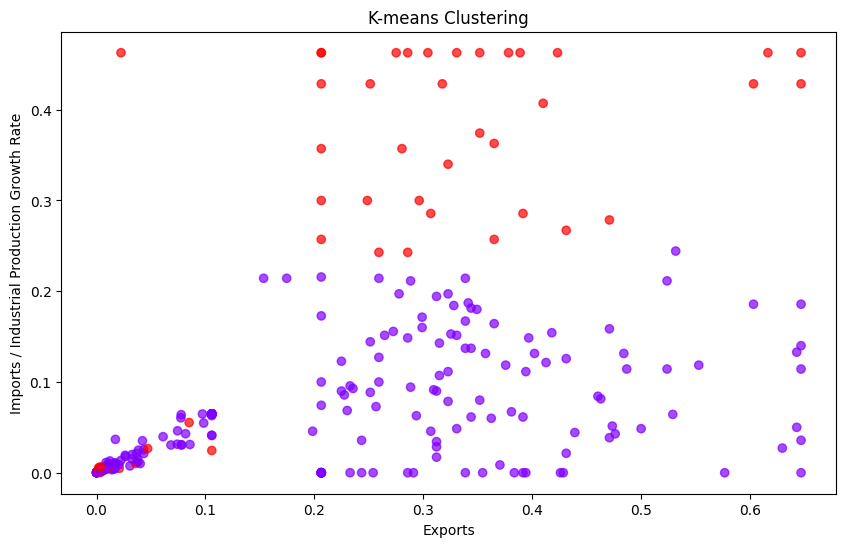

In [ ]:
result = kmeans(df, 2)
result

plt.figure(figsize=(10, 6))
plt.scatter(result['Exports'], result['Imports'], c=result['cluster'], cmap='rainbow', alpha=0.7)
plt.scatter(result['Industrial production growth rate'], result['Unemployment rate'], c=result['cluster'], cmap='rainbow', marker='o', alpha=0.7)
plt.xlabel('Exports')
plt.ylabel('Imports / Industrial Production Growth Rate')
plt.title('K-means Clustering')
plt.show()